In [1]:
import src.backtest_utils as sbtu
import pickle
import pandas as pd

In [2]:
_data_loader = sbtu.DataLoader.init_from_paths('other.json', 'base.json')
_strategy_path = _data_loader.file_path('strategy_lookup.pkl')
with open(_strategy_path, 'rb') as f:
    _strategy_lookup = pickle.load(f)

_bench_str = 'SPY'
_interval = '15m'
_price_data = pd.read_csv(_data_loader.history_path(_bench_str, _interval), index_col=0, header=[0,1]).iloc[1:].astype('float64')
_price_data.index = pd.to_datetime(_price_data.index, utc=True)
_bench = pd.read_csv(_data_loader.bench_path(_bench_str, _interval), index_col=0).astype('float64')
_bench.index = pd.to_datetime(_bench.index, utc=True)
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_strategy_overview = pd.read_csv(_data_loader.file_path('stat_overview_15m.csv'))

_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()

<AxesSubplot:>

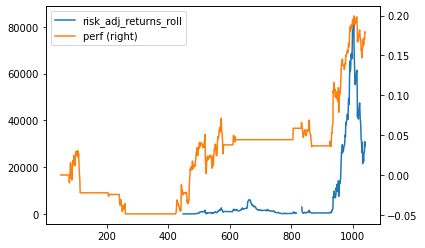

In [9]:
symbol = 'DXCM'
_stats = _strategy_lookup[symbol].stat_historical

_stats[['risk_adj_returns_roll', 'perf']].plot(use_index=False, secondary_y=['perf'])


<AxesSubplot:>

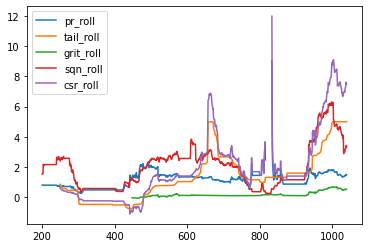

In [10]:
plot_copy = _stats[['pr_roll', 'tail_roll', 'grit_roll', 'sqn_roll', 'csr_roll']]
plot_copy.plot(use_index=False)

<AxesSubplot:title={'center':'DXCM'}>

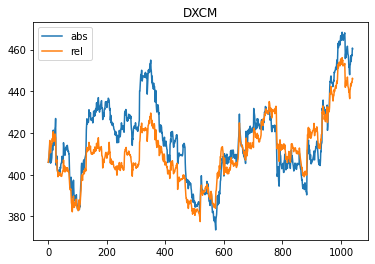

In [11]:
# base = 90
# for i in range(10):
#     quick_plot(base+i)
import src.utils.regime as sur
_symbol_data = _price_data_by_symbol.data[symbol]
_abs_rel_close = pd.DataFrame(
    data={
        'abs': _symbol_data.close,
        'rel': sur.simple_relative(_symbol_data, _bench.close).close
    }
)
_abs_rel_close.plot(title=symbol, use_index=False)

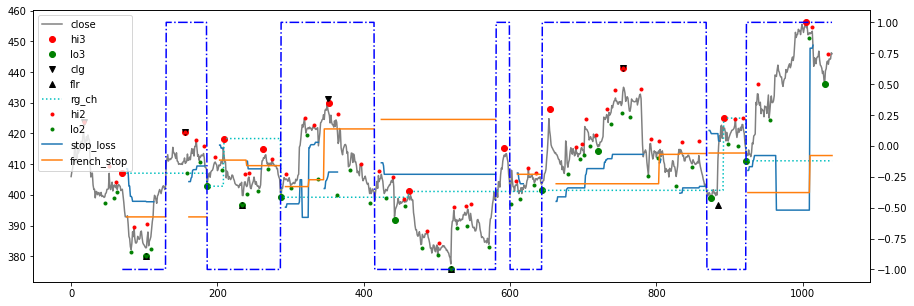

In [12]:
import src.scanner as scanner
epd = _strategy_lookup[symbol].enhanced_price_data.copy()
epd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price
epd['stop_loss'] = _strategy_lookup[symbol].stop_loss_series
# epd['base_close'] = _symbol_data.close
scanner.enhanced_price_data_plot(epd)


<AxesSubplot:>

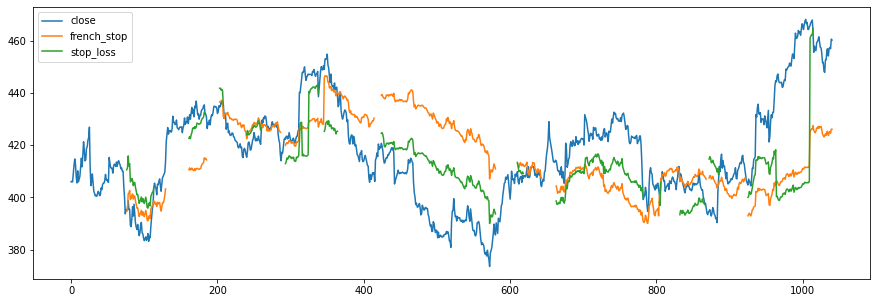

In [13]:
_sd = _symbol_data.copy()
_sd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price * (_bench.close/_bench.close.iloc[0])
_sd['stop_loss'] = _strategy_lookup[symbol].stop_loss_series * (_bench.close/_bench.close.iloc[0])
_sd[['close', 'french_stop', 'stop_loss']].plot(use_index=False, figsize=(15, 5))

<AxesSubplot:>

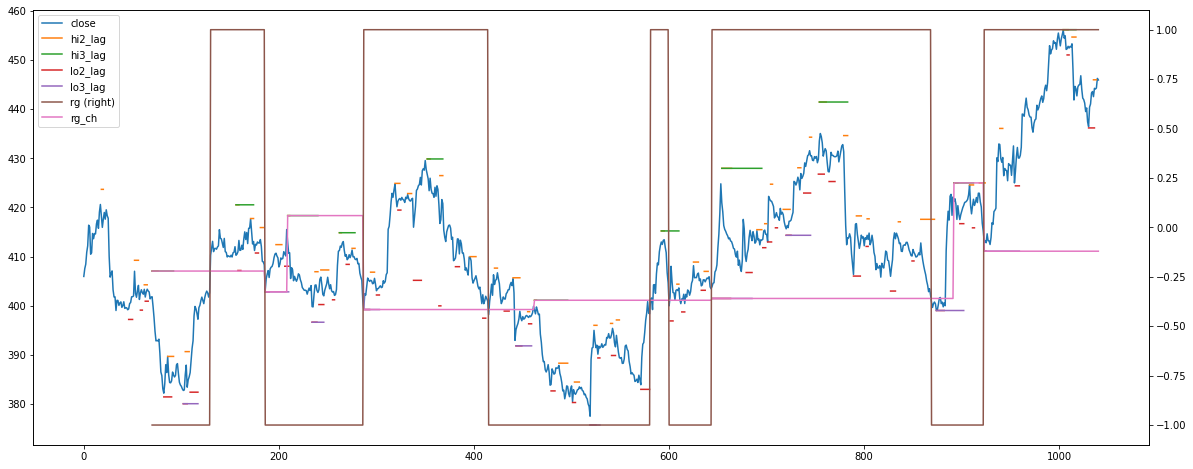

In [14]:
# scanner.rolling_plot(
#     _symbol_data,
#     epd,
#     stop_loss_t=_strategy_lookup[symbol].stop_loss_series,
#     ticker=symbol
# )
import src.pd_accessors as pda
import numpy as np
_pt = _strategy_lookup[symbol].peak_table.copy()

_pt['px'] = np.where(
    _pt.type == 1,
    epd.low.loc[_pt.start],
    epd.high.loc[_pt.start],
)
_pt = pda.PeakTable(_pt)
_pt = _pt.unpivot('15T', _symbol_data.index)
_shi_px = _pt.loc[(_pt.type == -1)]
_shi_2 = _shi_px.loc[(_shi_px.lvl == 2)]
_shi_3 = _shi_px.loc[(_shi_px.lvl == 3)]

_slo_px = _pt.loc[(_pt.type == 1)]
_slo_2 = _slo_px.loc[(_slo_px.lvl == 2)]
_slo_3 = _slo_px.loc[(_slo_px.lvl == 3)]

epd['hi2_lag'] = _shi_2.px
epd['hi3_lag'] = _shi_3.px
epd['lo2_lag'] = _slo_2.px
epd['lo3_lag'] = _slo_3.px


epd[
    ['close', 'hi2_lag', 'hi3_lag', 'lo2_lag', 'lo3_lag', 'rg', 'rg_ch']
].plot(use_index=False, figsize=(20, 8), secondary_y='rg')
